# pyVDJ tutorial

This tutorial is for pyVDJ v0.1.1. The package is available here: https://github.com/veghp/pyVDJ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc  # v1.4.3
import pyvdj
import upsetplot

In [2]:
sc.settings.set_figure_params(dpi=100)

In [3]:
adata = sc.read_h5ad('data/anndata.h5ad')
adata.shape

(12891, 1265)

Our example dataset contains T lymphocytes:

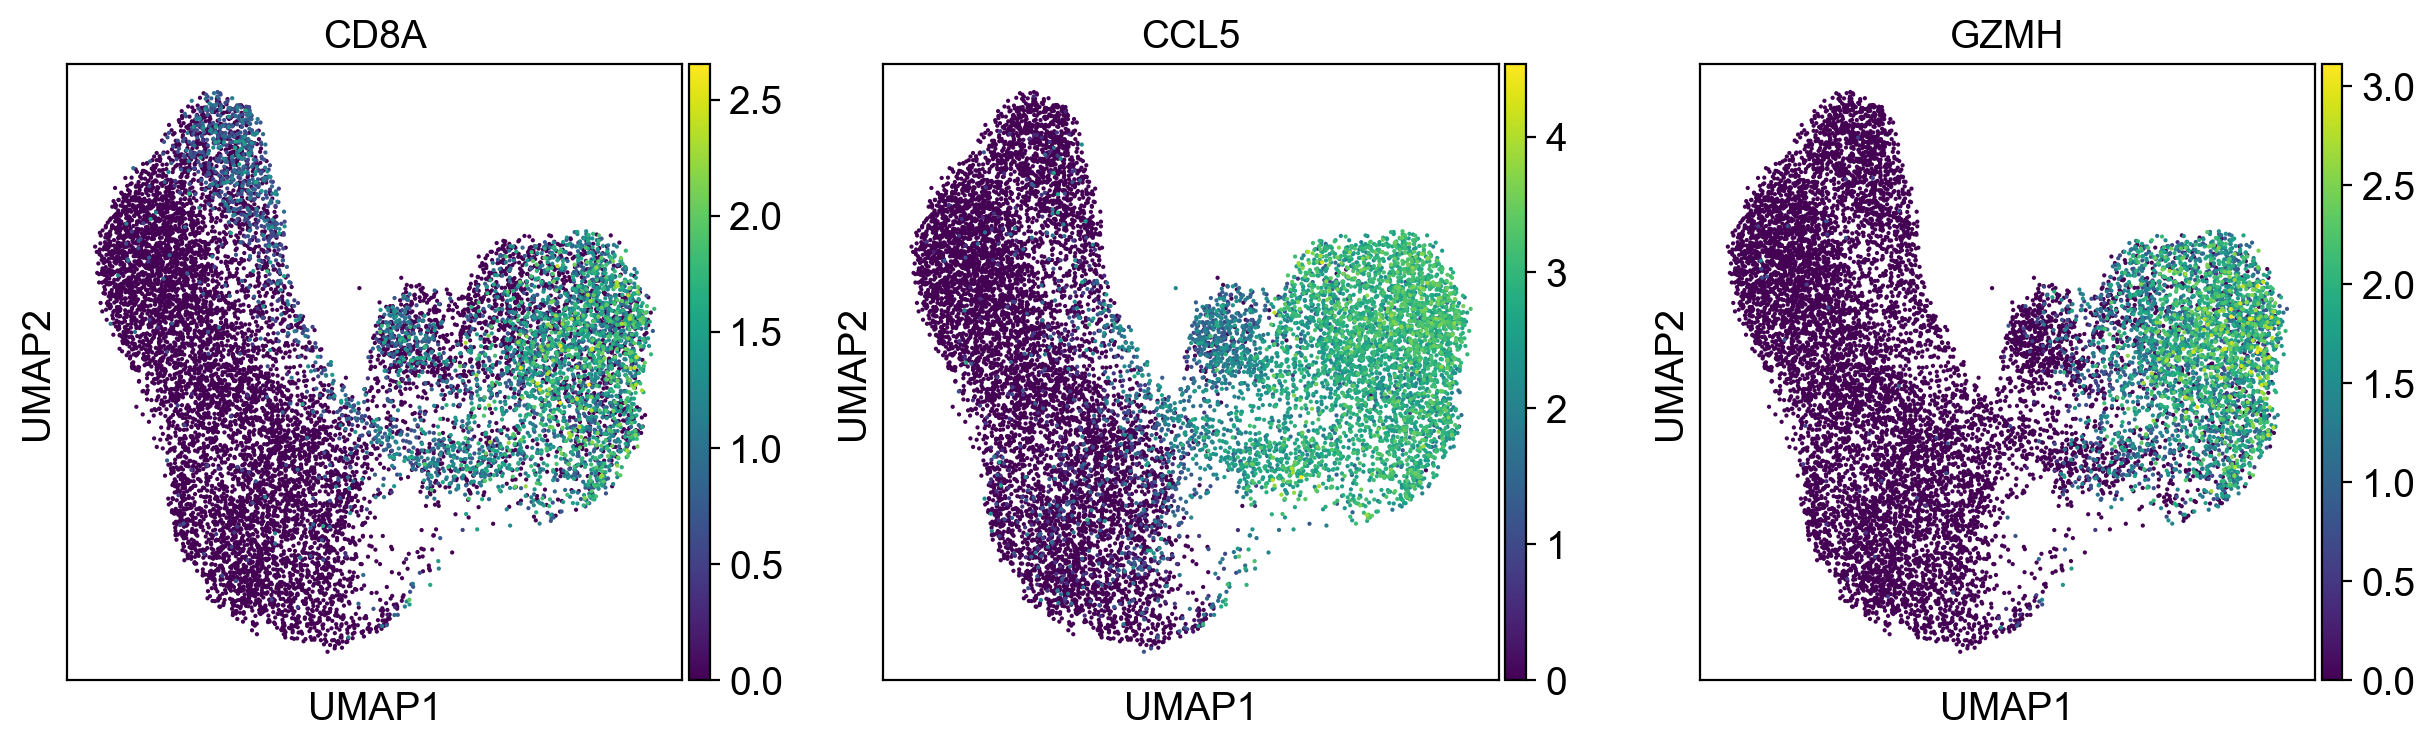

In [4]:
sc.pl.umap(adata, color=['CD8A', 'CCL5', 'GZMH'], use_raw=False)

The Th and the CD8+ Tc are clearly separated. A subcluster of Tc expresses CCL5, granzymes and other effector proteins. We use this dataset to demonstrate the functions of **pyVDJ**. The dataset consists of three donors, and two conditions (control and gain-of-function).

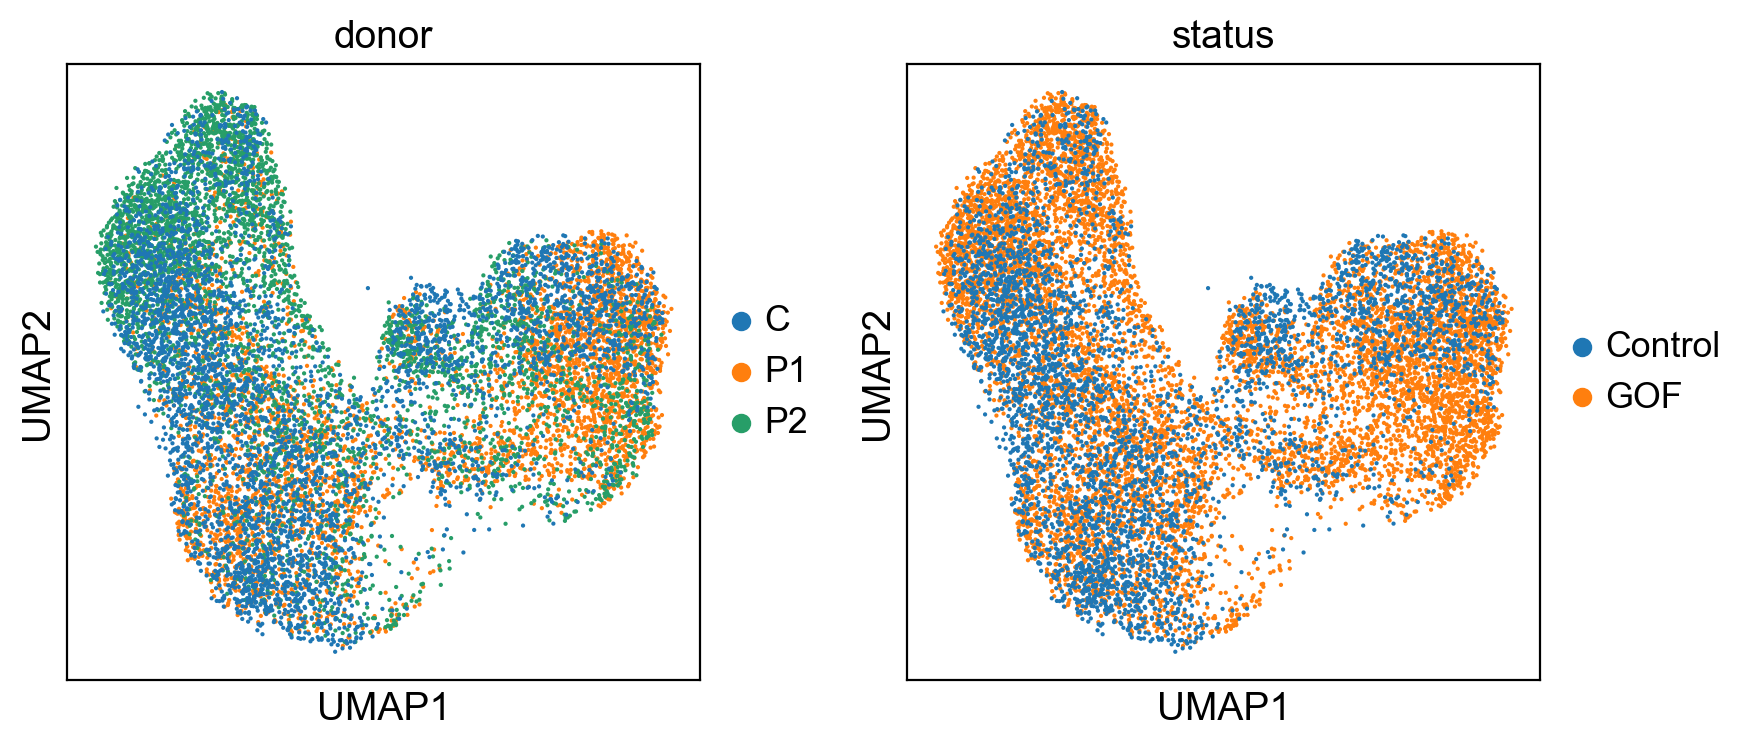

In [5]:
sc.pl.umap(adata, color=['donor', 'status'], use_raw=False)

## Load VDJ data

To load in the VDJ data, we construct filepaths and a dictionary linking files to sample names. The easiest way is to prepare a manifest that lists the GEX sample names next to the V(D)J 10x directory names in a csv file.

In [7]:
manifest = pd.read_csv('sample_manifest.csv')
manifest = manifest[manifest['metadata'].isin(adata.obs['metadata'].unique())]  # keep the ones in adata
#~ manifest = manifest[manifest['VDJ'].notnull()]  # can remove samples which have no VDJ (we have VDJ for all GEX)

# Construct paths to VDJ csv files:
paths = 'data/VDJ/' + manifest['VDJ'] + '/filtered_contig_annotations.csv'
samples = dict(zip(paths, manifest['metadata']))
samples

{'data/VDJ/5706STDY7883005/filtered_contig_annotations.csv': 'c1_P1_gof_Untreated_A',
 'data/VDJ/5706STDY7883006/filtered_contig_annotations.csv': 'c2_P1_gof_Untreated_A',
 'data/VDJ/5706STDY7883007/filtered_contig_annotations.csv': 'c3_P1_gof_Untreated_B',
 'data/VDJ/5706STDY7883008/filtered_contig_annotations.csv': 'c4_P2_gof_Untreated_A',
 'data/VDJ/5706STDY7883009/filtered_contig_annotations.csv': 'c5_P2_gof_Untreated_A',
 'data/VDJ/5706STDY7883010/filtered_contig_annotations.csv': 'c6_P2_gof_Untreated_B',
 'data/VDJ/5706STDY7883011/filtered_contig_annotations.csv': 'c7_C_normal_Untreated_A',
 'data/VDJ/5706STDY7883012/filtered_contig_annotations.csv': 'c8_C_normal_Untreated_B'}

##### Prepare metadata column

The AnnData object must contain a metadata column (e.g. `adata.obs['vdj_obs']`) of the following format: `cellbarcode + '_' + samplename`. This can be constructed from the cell barcodes and sample names (provided that we have sample annotation):

    #~ cellnames = adata.obs_names
    #~ cellbarcode = cellnames.str.split("-").str[:2].str.join("-") # cell barcode part + '-1'
    #~ adata.obs['vdj_obs'] = cellbarcode.astype(str) + "_" + adata.obs['Sample'].astype(str)

We then read V(D)J data into the AnnData object and create annotations. Note that values in the `filtered_contig_annotations.csv` files cannot be directly added as annotations, because one cell may have 0 to n values per entry. It will be stored in `adata.uns` and annotation will be generated separately.

##### Load data

In [8]:
adata = pyvdj.load_vdj(samples, adata, obs_col='vdj_obs', cellranger=2)

This loaded 10x V(D)J sequencing data (i.e. filtered_contig_annotations.csv files) into adata.uns['pyvdj']. `obs_col` specifies the annotation column for cellnames, as prepared above. For Cell Ranger version 3, set the parameter to 3.
For definitions of some words (clone, clonotype etc) used in the next section, see https://github.com/veghp/pyVDJ.

## VDJ annotation

In [9]:
adata = pyvdj.add_obs(adata, obs=['clonotype', 'is_clone', 'is_productive'])

This generates annotation in `adata.obs`. Now we can plot V(D)J properties:

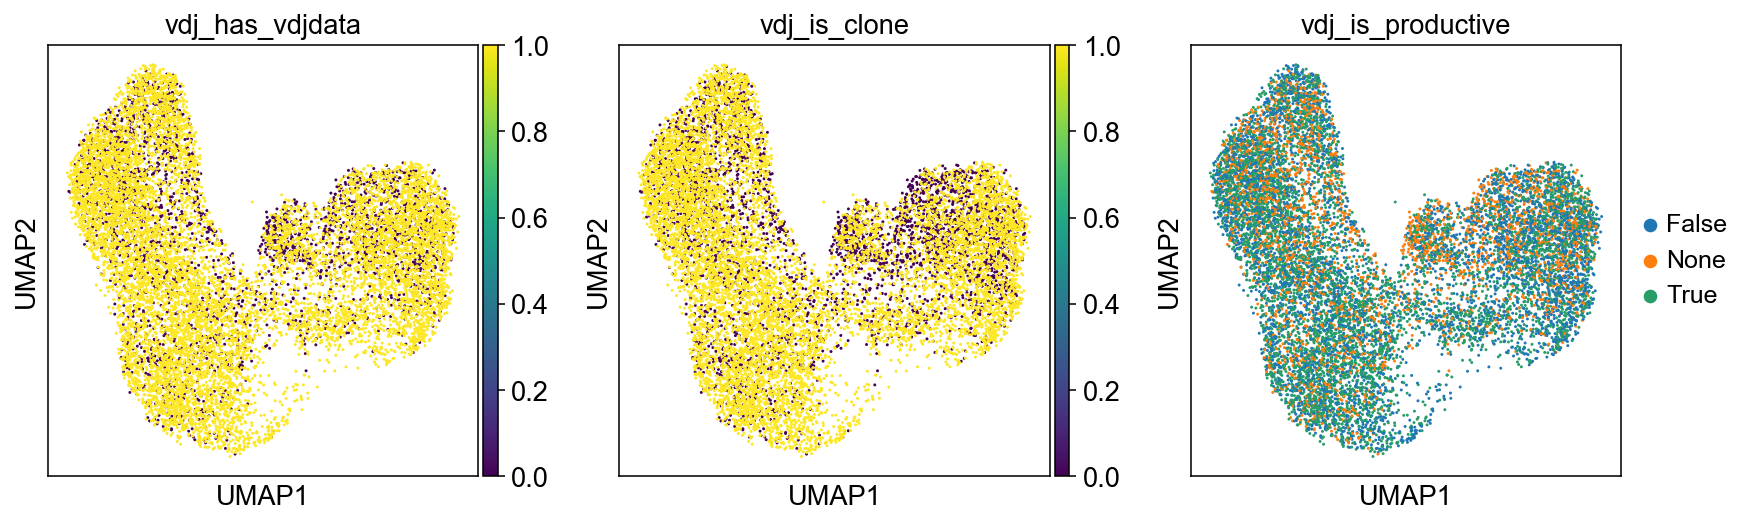

In [11]:
sc.settings.set_figure_params(dpi=70)
sc.pl.umap(adata, color=['vdj_has_vdjdata', 'vdj_is_clone', 'vdj_is_productive'])

In [21]:
allcell = len(adata.obs['vdj_has_vdjdata'])
vdjcell = sum(adata.obs['vdj_has_vdjdata'])
print('We have %d cells with VDJ data, out of %d cells.' % (vdjcell, allcell))

We have 9994 cells with VDJ data, out of 12891 cells.


In [24]:
n_prod = sum(adata.obs['vdj_is_productive'] == 'True')
print('There are %d cells which have only productive chains.' % (n_prod))

There are 5259 cells which have only productive chains.


This will be extended in the future to report cells which have no productive chain.

The following command adds one metadata column for each type of chain found in the V(D)J data:

In [25]:
adata = pyvdj.add_obs(adata, obs=['chains'])

TRG
TRB
Multi
IGL
TRA
IGH
IGK
TRD
None


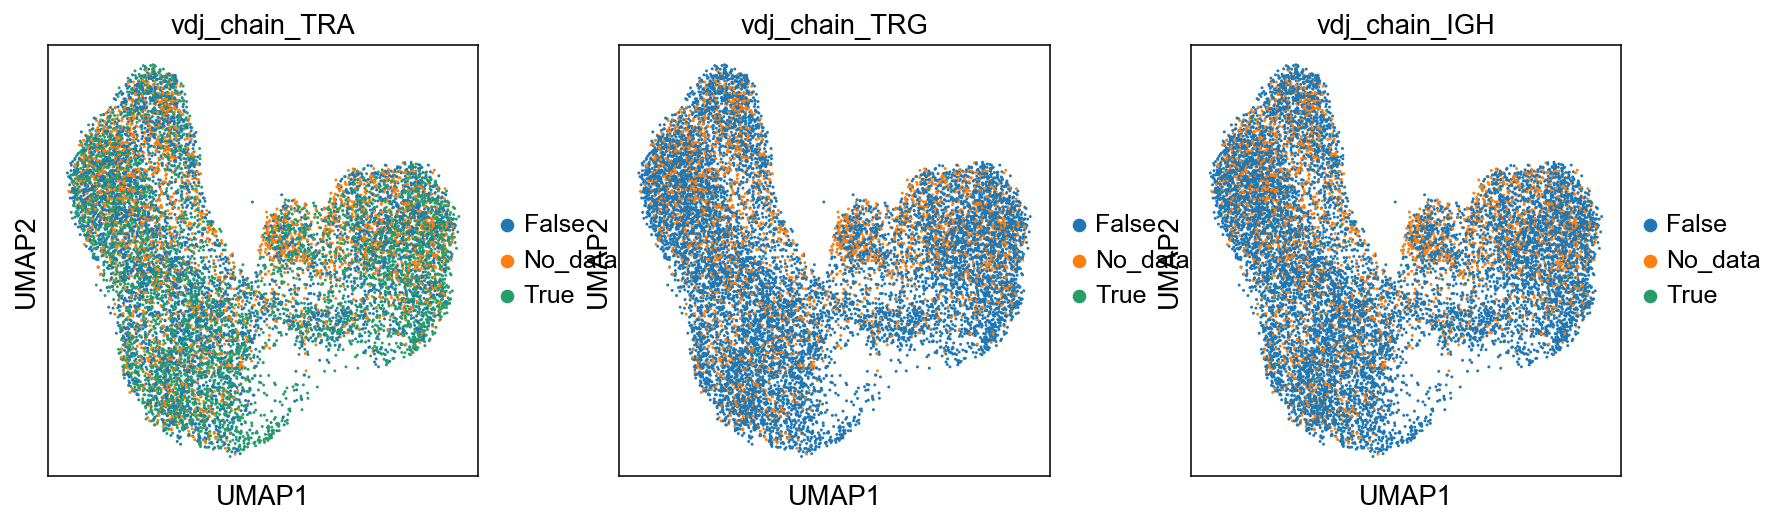

In [27]:
sc.pl.umap(adata, color=['vdj_chain_TRA', 'vdj_chain_TRG', 'vdj_chain_IGH'])

Most of the cells have alpha / beta chain. This was observed in other 10x datasets too (not shown).

In [28]:
adata = pyvdj.add_obs(adata, obs=['genes']) # one annotation for each gene

None
TRBC1
TRBC2
TRAC
IGHM
TRGC1
IGHA1
IGHE
IGHA2
IGHG1
IGLC1
IGHG4
IGHD
IGHG3
IGKC
TRDC
IGHG2
Preparing annotation for None
Preparing annotation for TRBC1
Preparing annotation for TRBC2
Preparing annotation for TRAC
Preparing annotation for IGHM
Preparing annotation for TRGC1
Preparing annotation for IGHA1
Preparing annotation for IGHE
Preparing annotation for IGHA2
Preparing annotation for IGHG1
Preparing annotation for IGLC1
Preparing annotation for IGHG4
Preparing annotation for IGHD
Preparing annotation for IGHG3
Preparing annotation for IGKC
Preparing annotation for TRDC
Preparing annotation for IGHG2


... storing 'vdj_constant_None' as categorical
... storing 'vdj_constant_TRBC1' as categorical
... storing 'vdj_constant_TRBC2' as categorical
... storing 'vdj_constant_TRAC' as categorical
... storing 'vdj_constant_IGHM' as categorical
... storing 'vdj_constant_TRGC1' as categorical
... storing 'vdj_constant_IGHA1' as categorical
... storing 'vdj_constant_IGHE' as categorical
... storing 'vdj_constant_IGHA2' as categorical
... storing 'vdj_constant_IGHG1' as categorical
... storing 'vdj_constant_IGLC1' as categorical
... storing 'vdj_constant_IGHG4' as categorical
... storing 'vdj_constant_IGHD' as categorical
... storing 'vdj_constant_IGHG3' as categorical
... storing 'vdj_constant_IGKC' as categorical
... storing 'vdj_constant_TRDC' as categorical
... storing 'vdj_constant_IGHG2' as categorical


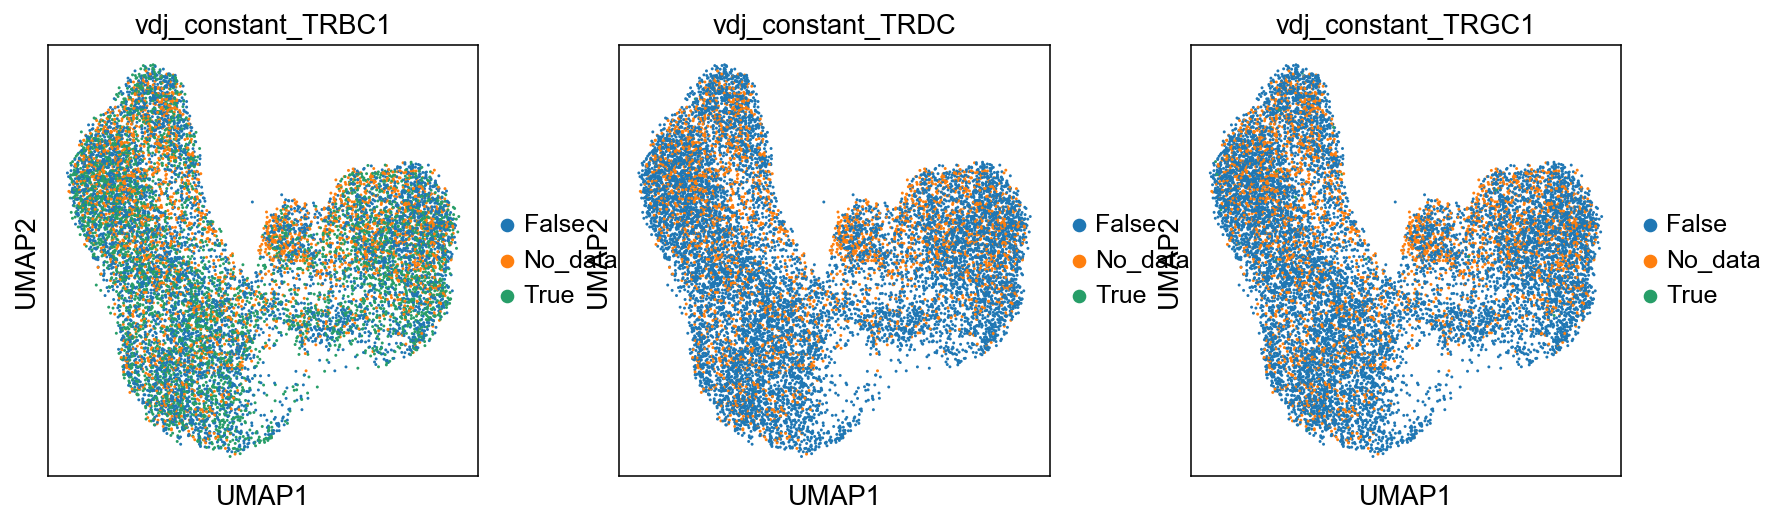

In [29]:
sc.pl.umap(adata, color=['vdj_constant_TRBC1', 'vdj_constant_TRDC', 'vdj_constant_TRGC1'])

Similarly, we can add annotation for each V and each J gene: 

`adata = pyvdj.add_obs(adata, obs=['v_genes', 'j_genes'])`

We can flag which cells are members of a clonotype with not fewer than _n_ clones:

In [32]:
adata = pyvdj.add_gt_n(adata, n=40)

... storing 'vdj_clonotype_gt_40' as categorical


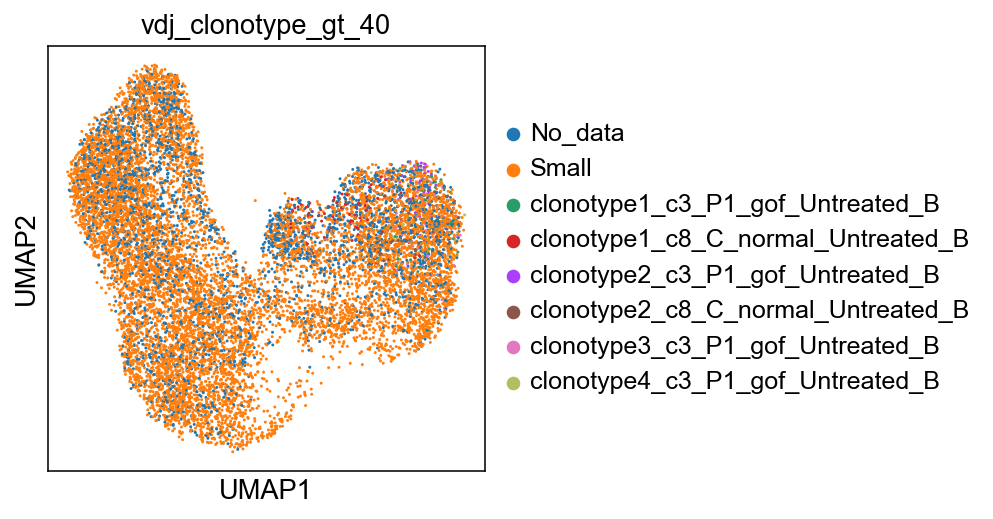

In [33]:
sc.pl.umap(adata, color='vdj_clonotype_gt_40')

We can see that the most expanded clonotypes are in the CCL5 (granzyme, etc)-expressing group.

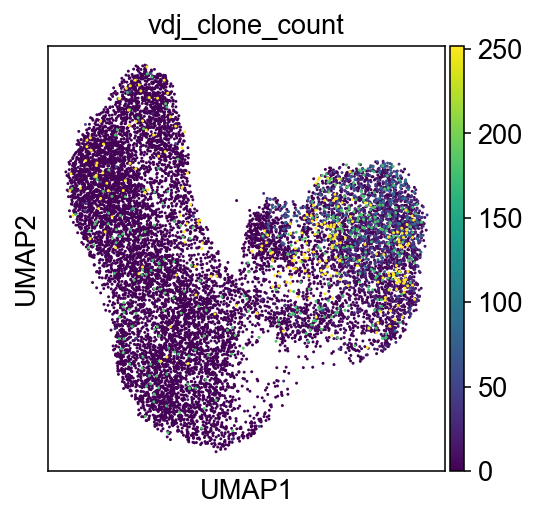

In [35]:
adata = pyvdj.add_obs(adata, obs=['clone_count'])
sc.pl.umap(adata, color='vdj_clone_count')

The plot shows the number of clones in each cell's clonotype, and provides an alternative view of expanded clonotypes. Let's retrieve the CDR3 amino acid sequences of the above clonotypes:

In [36]:
clonotypes = adata.obs['vdj_clonotype_gt_40'].unique()[2:].tolist()
cdr3_dict = pyvdj.get_spec(adata, clonotypes)
cdr3_dict

clonotype2_c8_C_normal_Untreated_B
clonotype1_c8_C_normal_Untreated_B
clonotype3_c3_P1_gof_Untreated_B
clonotype2_c3_P1_gof_Untreated_B
clonotype1_c3_P1_gof_Untreated_B
clonotype4_c3_P1_gof_Untreated_B


{'clonotype2_c8_C_normal_Untreated_B': ['CASSSYAEQYF',
  'CLVGDISGNQFYF',
  'CPTNTGNQFYF'],
 'clonotype1_c8_C_normal_Untreated_B': ['CLAGLSSYEQYF',
  'CASSLRAGGPHGELFF',
  'CALARGSTLGRLYF'],
 'clonotype3_c3_P1_gof_Untreated_B': ['CASSQDRETQYF', 'CAASRPLNTDKLIF'],
 'clonotype2_c3_P1_gof_Untreated_B': ['CASSKEGCRQVVEGDASFTGELFF',
  'CASSQDRQTQYF',
  'CAASKIGSSNTGKLIF',
  'CISVPAARKGVDRWLRGTPRSPGELFF',
  'CVLLHRQTPGGFKTIF'],
 'clonotype1_c3_P1_gof_Untreated_B': ['CASSQDRQTQYF',
  'CASSKEGCRQVVEGDASFTGELFF',
  'CAASKIGSSNTGKLIF',
  'CASGGSYIPTF',
  'CVLLHRQTPGGFKTIF'],
 'clonotype4_c3_P1_gof_Untreated_B': ['CAASTHGSSNTGKLIF',
  'CASSQDRDRHGYTF',
  'CRVSGL*AKNIQYF']}

This can be used to find their specificity in CDR3 databases, such as [VDJdb](http://vdjdb.cdr3.net/).

## Clonotype distribution

Now we obtain statistics for each specified AnnData metadata category:

In [37]:
meta = 'metadata'
#~ adata.obs['metadata']  # one category for each 10x channel
adata = pyvdj.stats(adata, meta)

Adding CDR3 to adata.uns


If ran the first time, this will add a dictionary in `adata.uns['pyvdj']['cdr3']`, which stores a set of productive CDR3s for each cell:

In [ ]:
adata.uns['pyvdj']['cdr3']['cdr3sets']
adata.uns['pyvdj']['cdr3']['cdr3_codes']  # and a dictionary of {code: cdr3 set}
adata.uns['pyvdj']['cdr3']['cdr3_codes_rev']  # and the reverse dictionary of {cdr3set: code}

This was used to calculate the statistics that was added as a dictionary (`adata.uns['pyvdj']['stats'][meta]`):

In [38]:
adata.uns['pyvdj']['stats'][meta].keys()

dict_keys(['meta', 'cells', 'clonotype_counts', 'clonotype_dist', 'cdr3'])

See the [readme](https://github.com/veghp/pyVDJ) for details on output.

In [40]:
# We define a plotting function. For easy customization, it is not included in the package.
def plot_cells(stats_dict):
    hasvdj = stats_dict['cells'][1]
    novdj = stats_dict['cells'][0] - hasvdj

    bars = np.add(hasvdj, novdj).tolist()
     
    x_axis = list(range(0, len(bars)))  # bar positions on x
    x_names = list(hasvdj.index)
    barWidth = 1

    p1 = plt.bar(x_axis, hasvdj, color='#553864', edgecolor='white', width=barWidth)
    p2 = plt.bar(x_axis, novdj, bottom=hasvdj, color='#81a75d', edgecolor='white', width=barWidth)
    plt.legend((p1[0], p2[0]), ('Has VDJ', 'No VDJ'), ncol=2, bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
    plt.grid(False)
    plt.xticks(x_axis, x_names, rotation='vertical')
    plt.subplots_adjust(bottom=0.4, left=0.2)
    plt.xlabel(stats_dict['meta'])
    plt.ylabel('Number of cells')


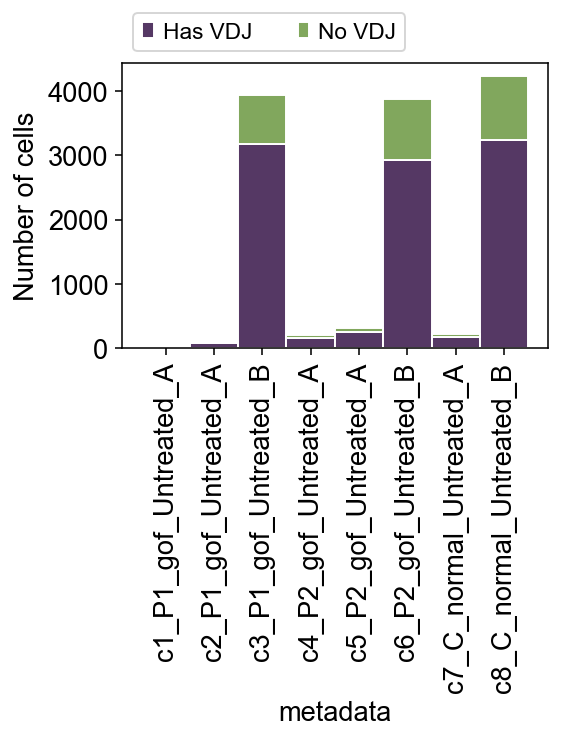

In [41]:
# Now we can plot cell numbers:
plot_cells(adata.uns['pyvdj']['stats'][meta])

Plot clonotype distribution for each sample:

c1_P1_gof_Untreated_A


/Users/peter/miniconda3/envs/hcaskin/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """


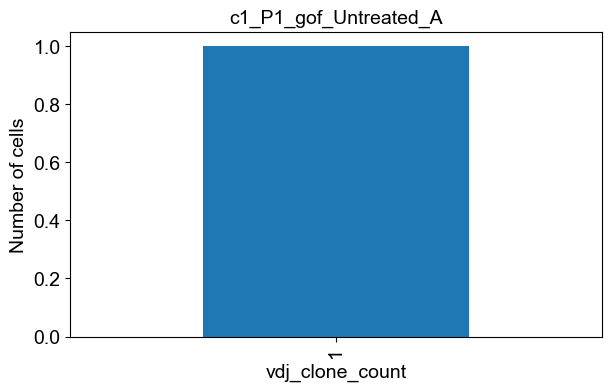

c2_P1_gof_Untreated_A


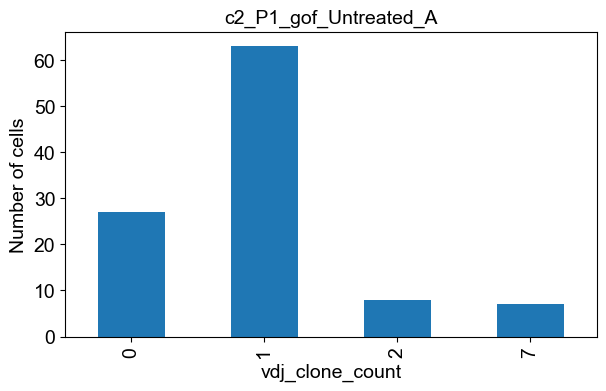

c3_P1_gof_Untreated_B


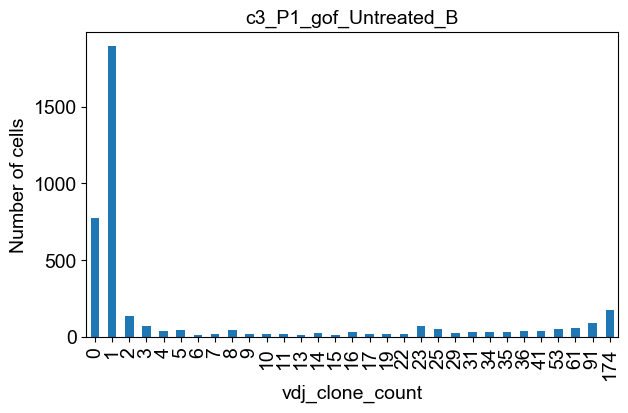

c4_P2_gof_Untreated_A


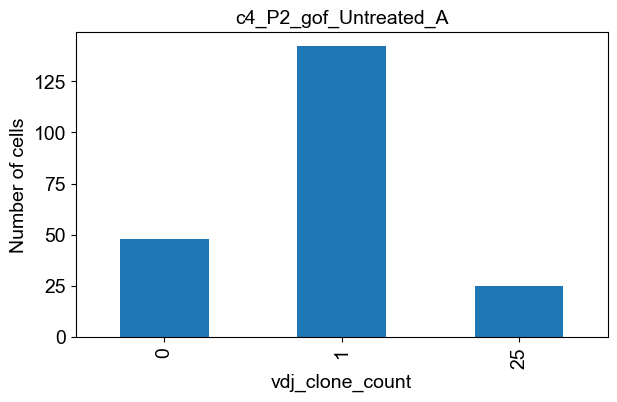

c5_P2_gof_Untreated_A


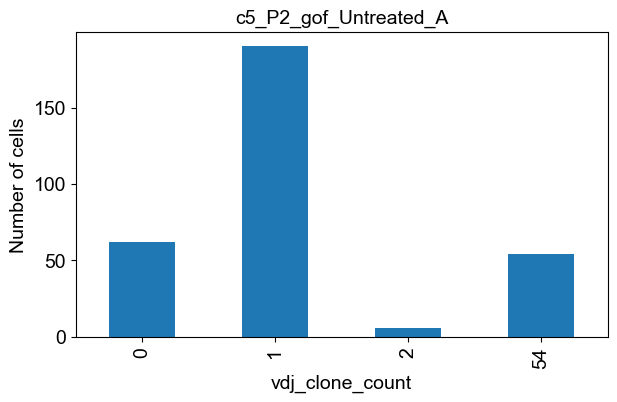

c6_P2_gof_Untreated_B


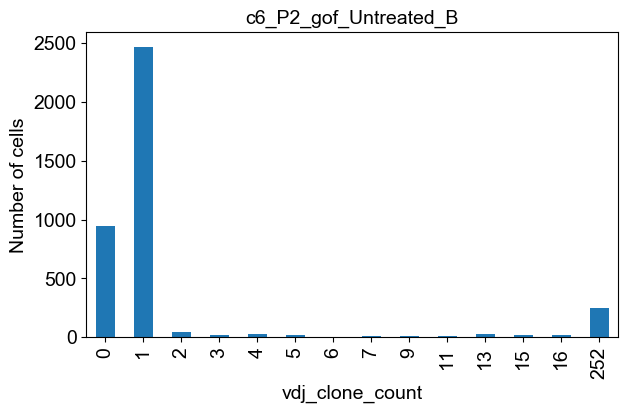

c7_C_normal_Untreated_A


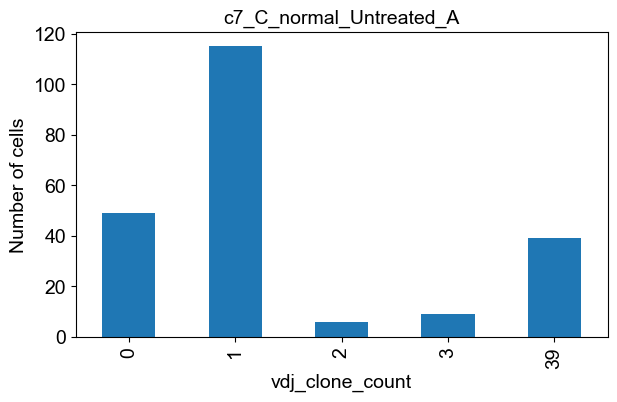

c8_C_normal_Untreated_B


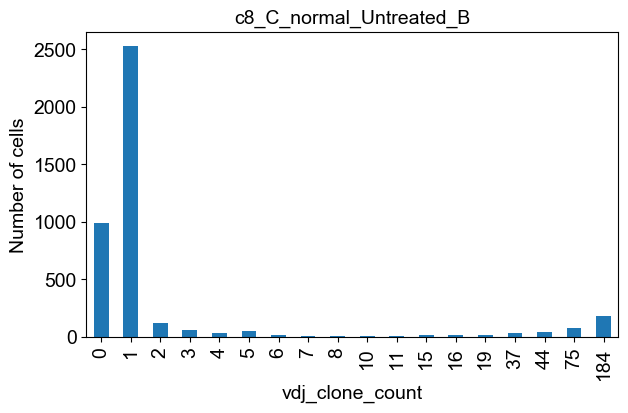

In [55]:
sc.settings.set_figure_params(dpi=50)
clonotype_dist = adata.uns['pyvdj']['stats'][meta]['clonotype_dist']
for meta_item in adata.obs[meta].unique().tolist():
    print(meta_item)
    clonotype_dist[meta_item].sort_index().plot('bar', figsize=(7, 5))
    plt.subplots_adjust(bottom=0.3, left=0.2)
    plt.grid(False)
    plt.title(meta_item)
    plt.ylabel('Number of cells')
    plt.show()


Apparently, more clonotypes are in the control (normal) sample (C), than in GOF (P1). This could be due to either decreased diversity in GOF, or expansion of a few clonotypes in GOF, which makes it more likely to sample those cells.

In our data, P2 is a non-adult sample, and that could explain the lack of clonotype expansion.

We can plot in a slightly different way, with x-axis being a proper number line:

In [44]:
x_max = max(adata.obs['vdj_clone_count'])
x_max = int(x_max*1.05)

samples_plot = ['c8_C_normal_Untreated_B', 'c3_P1_gof_Untreated_B', 'c6_P2_gof_Untreated_B', ]

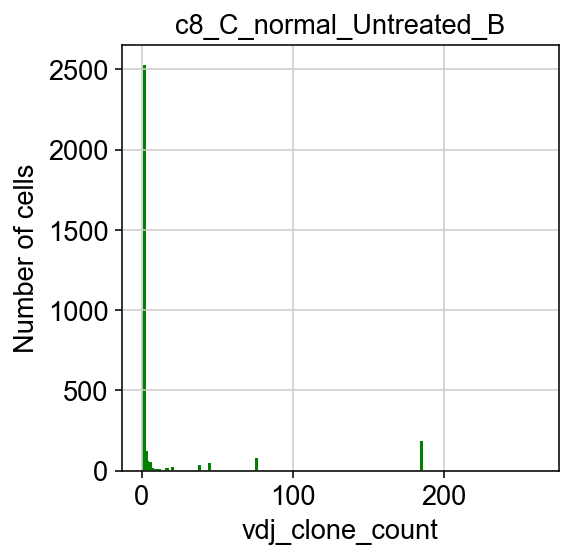

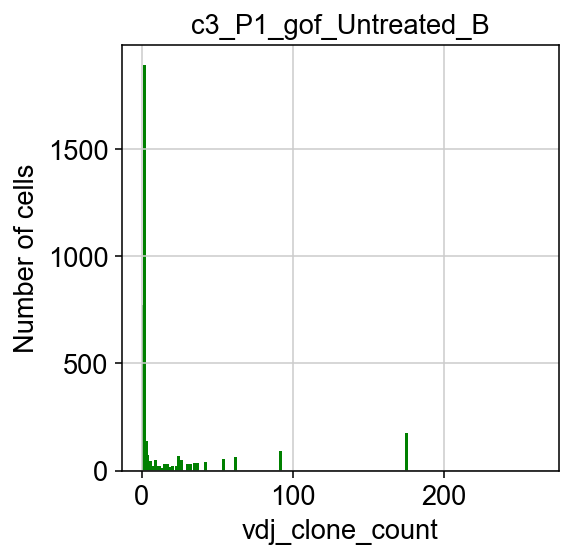

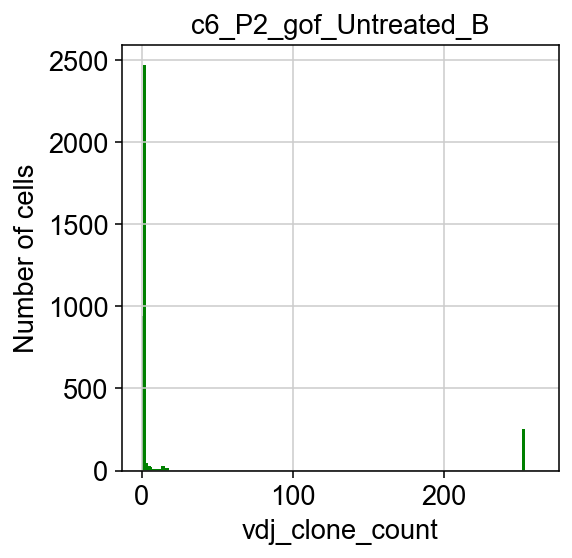

In [45]:
sc.settings.set_figure_params(dpi=70)
for s in samples_plot:
    df = adata.obs.loc[adata.obs[meta] == s]
    x1 = df['vdj_clone_count']
    plt.hist(x1, bins=range(0, x_max), width = 2, color='g', label=s)
    plt.title(s)
    plt.xlabel('vdj_clone_count')
    plt.ylabel('Number of cells')
    plt.show()


### Diversity indices

Which sample is the most diverse? We can make a simplified attempt to answer this by calculating the [Shannon](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index) and the [Simpson](https://en.wikipedia.org/wiki/Diversity_index#Simpson_index) diversity indices.

**The following code section can be applied to data from Cell Ranger version 3, and it will calculate the right indices.**

**However, version 2** assigns the same ID ('None') to clonotypes with only one clone. Therefore the input dictionary needs to be corrected by adding the right number of entries with count 1 (not shown here).

##### Diversity index of all clonotypes, for each 10x sample (channel)

In [46]:
vdjdf = adata.uns['pyvdj']['df']
vdjdf.columns

obs_col = adata.uns['pyvdj']['obs_col']  # this is an optional step: subsets for cells in anndata

vdjdf = vdjdf.loc[vdjdf['barcode_meta'].isin(adata.obs[obs_col])]

for s in vdjdf['sample'].unique():
    sd = dict(vdjdf.loc[(vdjdf['sample'] == s)].groupby('clonotype_meta').size())
    shannon_index = pyvdj.shannon(sd)
    simpson_index = pyvdj.simpson(sd)
    print(s)
    print('The Shannon index for %s is %s.' % (s, shannon_index))
    print('The Simpson index for %s is %s.' % (s, simpson_index))
    print()
    print()


c1_P1_gof_Untreated_A
The Shannon index for c1_P1_gof_Untreated_A is -0.0.
The Simpson index for c1_P1_gof_Untreated_A is 1.0.


c2_P1_gof_Untreated_A
The Shannon index for c2_P1_gof_Untreated_A is 4.018289470956628.
The Simpson index for c2_P1_gof_Untreated_A is 0.0235169771436121.


c3_P1_gof_Untreated_B
The Shannon index for c3_P1_gof_Untreated_B is 6.682369914980537.
The Simpson index for c3_P1_gof_Untreated_B is 0.006579825570850215.


c4_P2_gof_Untreated_A
The Shannon index for c4_P2_gof_Untreated_A is 4.444219411754031.
The Simpson index for c4_P2_gof_Untreated_A is 0.0392297781144586.


c5_P2_gof_Untreated_A
The Shannon index for c5_P2_gof_Untreated_A is 4.399385371764982.
The Simpson index for c5_P2_gof_Untreated_A is 0.06829827700634802.


c6_P2_gof_Untreated_B
The Shannon index for c6_P2_gof_Untreated_B is 7.3265019743656765.
The Simpson index for c6_P2_gof_Untreated_B is 0.0069757374912854915.


c7_C_normal_Untreated_A
The Shannon index for c7_C_normal_Untreated_A is 4.0967

Note that in the literature the inverse Simpson index (i.e. 1 / index ) is often (erroneously) referred to as the Simpson index.

##### Diversity index of all clonotypes, for each metadata category, for each 10x sample (channel)

The above can be expanded to calculate these indices separately for each metadata category:

In [49]:
vdjdf = vdjdf.loc[vdjdf['barcode_meta'].isin(adata.obs[obs_col])]
meta_cat = 'status'

In [50]:
for m in adata.obs[meta_cat].unique():
    m_cells = adata.obs.loc[(adata.obs[meta_cat] == m)][obs_col]
    vdjdf_m = vdjdf.loc[vdjdf['barcode_meta'].isin(m_cells)]
    for s in vdjdf_m['sample'].unique():
        sd = dict(vdjdf_m.loc[(vdjdf_m['sample'] == s)].groupby('clonotype_meta').size())
        shannon_index = pyvdj.shannon(sd)
        simpson_index = pyvdj.simpson(sd)
        print(s)
        print('The Shannon index for sample %s in category %s is %s.' % (s, m, shannon_index))
        print('The Simpson index for sample %s in category %s is %s.' % (s, m, simpson_index))
        print()
        print()


c1_P1_gof_Untreated_A
The Shannon index for sample c1_P1_gof_Untreated_A in category GOF is -0.0.
The Simpson index for sample c1_P1_gof_Untreated_A in category GOF is 1.0.


c2_P1_gof_Untreated_A
The Shannon index for sample c2_P1_gof_Untreated_A in category GOF is 4.018289470956628.
The Simpson index for sample c2_P1_gof_Untreated_A in category GOF is 0.0235169771436121.


c3_P1_gof_Untreated_B
The Shannon index for sample c3_P1_gof_Untreated_B in category GOF is 6.682369914980537.
The Simpson index for sample c3_P1_gof_Untreated_B in category GOF is 0.006579825570850215.


c4_P2_gof_Untreated_A
The Shannon index for sample c4_P2_gof_Untreated_A in category GOF is 4.444219411754031.
The Simpson index for sample c4_P2_gof_Untreated_A in category GOF is 0.0392297781144586.


c5_P2_gof_Untreated_A
The Shannon index for sample c5_P2_gof_Untreated_A in category GOF is 4.399385371764982.
The Simpson index for sample c5_P2_gof_Untreated_A in category GOF is 0.06829827700634802.


c6_P2_gof_

However, this will still treat each 10x channel as a separate donor, and clonotypes across 10x channels (but from the same donor) will not be combined. (In this context, [donor means](https://github.com/veghp/pyVDJ#definitions) an individual organism (human or animal).) This is addressed in the next section:

##### Diversity index of all clonotypes, for each donor (with clonotypes combined within donor)

In [52]:
sample_donor = dict(zip(adata.uns['pyvdj']['df']['sample'].unique(), ['P1', 'P1', 'P1', 'P2', 'P2', 'P2', 'C', 'C', ]))
sample_donor
adata = pyvdj.find_clones(adata, sample_donor)

P1
P2
C


Using the CDR3 _nucleotide_ sequences, the above combined clones within the same donor that were sequenced in different 10x channels and thus have different clonotype IDs. See:

    adata.uns['pyvdj']['df']['donor_clonotype_meta']
    adata.obs['vdj_donor_clonotype']


In [54]:
# Then we can calculate the indices:
for s in adata.obs['donor'].unique():
    sd = dict(adata.obs.loc[adata.obs['donor'] == s]['vdj_donor_clonotype'].value_counts())
    shannon_index = pyvdj.shannon(sd)
    simpson_index = pyvdj.simpson(sd)
    print(s)
    print('The Shannon index for %s is %s.' % (s, shannon_index))
    print('The Simpson index for %s is %s.' % (s, simpson_index))
    print()
    print()


P1
The Shannon index for P1 is 6.873767140041665.
The Simpson index for P1 is 0.005890461538461352.


P2
The Shannon index for P2 is 7.493786497487457.
The Simpson index for P2 is 0.0063991611039293525.


C
The Shannon index for C is 7.45620275097477.
The Simpson index for C is 0.004282503531311563.




## Private/public clones

Let's find public CDR3s! (i.e. CDR3s shared between donors)

There are two ways to approach this:

* We can **obtain all CDR3 sequences** for each condition, then find shared sequences. We provide an example in a section further below.

* A much stricter approach is to **find CDR3-combinations (clonotypes) shared between conditions**. This is more accurate, because the combination of two CDR3 sequences define the specificity of the TCR. One major disadvantage is that it will return very few positives. For this, we calculate statistics grouped by donor (as opposed to sample, i.e. 10x channel):


##### Finding public clonotypes

In [56]:
meta = 'donor'
adata = pyvdj.stats(adata, meta)
cdr3 = adata.uns['pyvdj']['stats'][meta]['cdr3']

In [57]:
set(cdr3['C']) & set(cdr3['P1']) & set(cdr3['P2'])

set()

As we can see, there are no clonotypes (as defined by the set of CDR3 sequences) shared between all 3 donors.

In [58]:
set(cdr3['P1']) & set(cdr3['P2']) - set(cdr3['C'])

{frozenset({'CASSPGLAAETQYF'})}

As we can see here and below, this strict approach returned clonotypes with only one CDR3 sequenced.
In any case, we can search these amino acid sequences in [vdjDB](https://vdjdb.cdr3.net/search). This one is not present in the database, which may mean it is a sequence potentially private (specific) to this condition. However, these databases are relatively small and capture a small part of the potential diversity of these sequences.


In [59]:
set(cdr3['C']) & set(cdr3['P1'])

{frozenset({'CASSSTSGAYNEQFF'}), frozenset({'CASSLYNEQFF'})}

'CASSLYNEQFF' is a CMV-specific sequence according to vdjDB. Cytomegalovirus (CMV) is a herpes virus that infects the majority of humans, therefore it is not surprising that a receptor against it was found in the two adult samples.

'CASSSTSGAYNEQFF' is not found in the database, but variants of it (with 1 aa difference) are specific to herpes viruses (CMV, EBV) and influenzA.

These searches will be more useful as these databases are extended with new data from 10x VDJ sequencing experiments. Note that this kind of analysis is complicated by that a TCR likely recognises many different antigens.

Perhaps the most useful part of the data is the GOF-specific CDR3s (that are not found in control):

In [61]:
len(set(cdr3['P1']) - set(cdr3['C']))

2086

A simple visualization of the above:

In [62]:
cdr3_codes_rev = adata.uns['pyvdj']['cdr3']['cdr3_codes_rev']

cdr3_coded = {}
for key, value in cdr3.items():
    print(key)
    cdr3_coded[key] = [cdr3_codes_rev[cdr3] for cdr3 in value]

cdr3_coded.keys()

C
P1
P2


dict_keys(['C', 'P1', 'P2'])

We create a multi-indexed table that can be used for the plotting function:

In [63]:
contents = upsetplot.from_contents(cdr3_coded)
contents

id
C     P1    P2         
False True  False     1
True  False False     2
            False     3
False True  False     4
True  False False     5
...                 ...
False False True   8506
True  False False  8507
False False True   8508
      True  False  8510
True  False False  8511

[7647 rows x 1 columns]

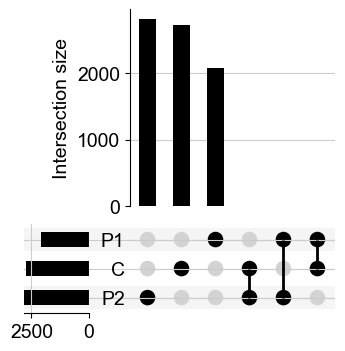

In [64]:
upsetplot.UpSet(contents, subset_size='count')

See [this for help](https://caleydo.org/tools/upset/) on reading [upsetplots](https://pypi.org/project/UpSetPlot/).

##### Finding public CDR3 sequences

We can use `get_spec()` with a list of clonotypes for each category, or obtain sequences directly from the data, filtered for cells as shown here:

In [ ]:
meta = 'status'
vdjdf = adata.uns['pyvdj']['df']
cdr3_simple_dict = {}

In [ ]:
for m in adata.obs[meta].unique():
    print(m)
    cells = adata.obs.loc[adata.obs[meta] == m][obs_col].tolist()
    cdr3_m = vdjdf.loc[vdjdf['barcode_meta'].isin(cells)]['cdr3']
    cdr3_simple_dict[m] = set(cdr3_m)


In [ ]:
cdr3_simple_dict.keys()

In [ ]:
gof_only = cdr3_simple_dict['GOF'] - cdr3_simple_dict['Control']
len(gof_only)

The putative GOF-specific CDR3s can be searched for in databases, as shown above.

In [ ]:
public_cdr3 = cdr3_simple_dict['GOF'] & cdr3_simple_dict['Control']
len(public_cdr3)

This returns a higher number of CDR3s shared between GOF and control. These are not specific to GOF.

## Saving data

Unfortunately, a bug in AnnData causes the saved `adata.uns['pyvdj']['df']` to turn into a numpy array upon loading. Therefore, it is recommended to save it separately, and load when necessary:

In [66]:
adata.uns['pyvdj']['df'].to_pickle(path='adata.pyvdj.df.pkl')
# And anndata:
#~ adata.write('data/anndata.h5ad')
